<a href="https://colab.research.google.com/github/Anshu00027/SAE-for-PINNs/blob/main/SAE-for-Taylor-Green-Vortex-PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#  Redefine Model Architecture
class TGV(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers) - 2):
            net.append(nn.Linear(layers[i], layers[i + 1]))
            net.append(nn.SiLU())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

# Step 4: Initialize and Load Weights

model = TGV([3, 15, 15, 15, 3])  # same architecture used when training
load_path = "/content/drive/MyDrive/Colab Notebooks/TGV(SAE)/saved_models/TGV_PSOAdam_weights.pth"

model.load_state_dict(torch.load(load_path))
model.eval()  # important: set model to evaluation mode

print("Model successfully loaded and ready for inference!")



Model successfully loaded and ready for inference!


In [8]:
rho = 4.0
nu = 1.0
n_points = 15
x_vals = np.linspace(0, np.pi, n_points)
y_vals = np.linspace(0, np.pi, n_points)
t_vals = np.linspace(0, 1, n_points)

X_grid, Y_grid, T_grid = np.meshgrid(x_vals, y_vals, t_vals, indexing="ij")

x_flat = X_grid.flatten()
y_flat = Y_grid.flatten()
t_flat = T_grid.flatten()

# Exactsolution

f_np = np.exp(-2 * nu * t_flat)
u_exact = np.sin(x_flat) * np.cos(y_flat) * f_np
v_exact = -np.cos(x_flat) * np.sin(y_flat) * f_np
p_exact = (rho / 4.0) * (np.cos(2 * x_flat) + np.cos(2 * y_flat)) * f_np**2


all_test = torch.tensor(np.stack([x_flat, y_flat, t_flat], axis=1), dtype=torch.float32)

model.eval()


TGV(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=15, bias=True)
    (1): SiLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): SiLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): SiLU()
    (6): Linear(in_features=15, out_features=3, bias=True)
  )
)

In [9]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model.net[-2].register_forward_hook(get_activation('last_hidden'))

with torch.no_grad():
    _ = model(all_test)

last_hidden = activations['last_hidden']
print(last_hidden.shape)  # (N_points, 15)


torch.Size([3375, 15])


In [10]:

activations_array = last_hidden.cpu().numpy()
print(activations_array.shape)

# Min-Max normalization
min_vals = activations_array.min(axis=0)
max_vals = activations_array.max(axis=0)

activations_normalized = (activations_array - min_vals) / (max_vals - min_vals)

print("Normalized range:", activations_normalized.min(), activations_normalized.max())

(3375, 15)
Normalized range: 0.0 1.0


 We are loading the data from a trained PINNs model with 2 hidden layers having 25 neurosn each(architecture [3, 15,15,15, 3]), solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 15 neurons
 These activations are collected for all training points().

So our complete data looks like:  

$$A = \begin{bmatrix} a_1 \\ a_2\\ \vdots \\ a_{N} \end{bmatrix} $$


where $a_k \in \mathbb{R}^{15} $ represents the activation values corresponding to the $k^{th}$ training point of the PDE domain,  


In other words, the SAE takes these activations as input and learns a latent representation of them through its encoder, while the decoder attempts to reconstruct the original activations as

$$\vec{y} = {\rm AE}(\vec{x})= \sigma_2(W_2 E(\vec{x}) + \vec{b}_2), E(\vec{x}) = \sigma_1(W_1 \vec{x} + \vec{b}_1) $$

$$\hat{a}_k = {\rm AE}(\vec{a}_k) $$


where $\hat{I}_k$ is the reconstructed activation vector.


The loss in the sparse autoencoder consists of two parts: **reconstruction loss** and **sparsity penalty**.

1. **Reconstruction loss**:
$$
L_{rec} = \frac{1}{m} \sum_{k=1}^{m} (a_k - \hat{a}_k)^2
$$

2. **Sparsity penalty**:

For each hidden neuron, the average activation across a mini-batch of size m is
$$
\hat{\rho_j} = \frac{1}{m} \sum_{i=1}^{m} h_j^i
$$
 where $h_j^i$ is activation of jth neuron for $i^{th}$ sample

The KL divergence between the target sparsity $\rho$ and the actual average activation $\hat{\rho_j}$ is
$$
\text{div}_j = \rho \log \frac{\rho}{\hat{\rho_j}} + (1-\rho) \log \frac{1-\rho}{1-\hat{\rho_j}}
$$
The total loss used for training the SAE is
$$
\text{Loss} = L_{rec} + \lambda \sum_{j=1}^{h_{dim}} \text{div}_j
$$
Here, $\lambda$ is a weighting factor(`sparsity_lamda`) that controls how strongly the sparsity constraint influences the total loss
This ensures the model reconstructs inputs accurately while maintaining sparsity in the hidden layer.



Normalization rescales neuron activations to a common range, making them easier to visualize, compare, and analyze.

| Theoretical Symbol | Code Variable |
|--------------------|---------------|
| $N$ | `number of training points` |
| $d_{in}$ | `in_dim` |
| $h_{dim}$ | `h_dim` |
| $\sigma_1$ | `nn.Sigmoid()` |
| $\sigma_2$ | `nn.Tanh()` |
| $\rho$ | `sparsity_target` |
| $\lambda$ | `sparsity_lambda` |
| $\hat{\rho}_j$ | `average activation` |
| $L_{rec}$ | `mse_loss` |
| $L$ | `loss` |
| $\eta$ | `lr` |
| — | `optimizer (Adam)` |
| m | `batch_size` |
| — | `n_epochs` |

In [11]:
hidden_tensor = torch.tensor(activations_normalized, dtype=torch.float32)

print(hidden_tensor.shape)

torch.Size([3375, 15])


To improve training efficiency, we divide the data into mini-batches of 139 samples, allowing the model to iteratively update weights over multiple batches per epoch with shuffuling

Xavier initialization is used to initialize the weights, ensuring a stable start for training.

In [12]:

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=135, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):
        super().__init__()

        # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
        # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.

        self.xavier_norm_init = xavier_norm_init
       # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        # The decoder reconstructs the original input from the compressed hidden representation.
        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)



During training, the full dataset of neuron activations is divided into **mini-batches**. Each mini-batch contains a subset of the total samples (e.g., 139 samples per batch in our case), which is fed into the sparse autoencoder at a time. This approach allows the model to **update its weights iteratively** after processing each batch rather than waiting to process the entire dataset.

Using mini-batches improves **training efficiency**, reduces memory usage, and can help the model converge faster. In the code, the `DataLoader` automatically selects these mini-batches in a **random order for each epoch** if `shuffle=True`, ensuring that the model sees different combinations of samples over training epochs.



>>> Training SAE | h_dim=50, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.300241421
Epoch 500/3000 - Loss: 0.000397593
Epoch 1000/3000 - Loss: 0.000088537
Epoch 1500/3000 - Loss: 0.000043290
Epoch 2000/3000 - Loss: 0.000029549
Epoch 2500/3000 - Loss: 0.000023026
 Done: h_dim=50, sparsity_target=0.01, Final Loss=0.000018825



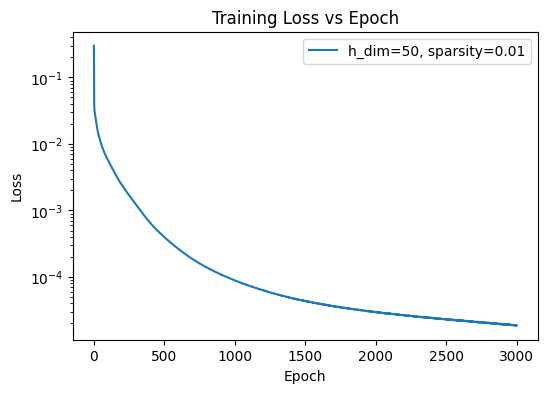

 Done: h_dim=50, sparsity_target=0.01, Final Loss=0.000018825


>>> Training SAE | h_dim=50, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.381408513
Epoch 500/3000 - Loss: 0.000209788
Epoch 1000/3000 - Loss: 0.000037077
Epoch 1500/3000 - Loss: 0.000022086
Epoch 2000/3000 - Loss: 0.000016859
Epoch 2500/3000 - Loss: 0.000014339
 Done: h_dim=50, sparsity_target=0.04, Final Loss=0.000013247



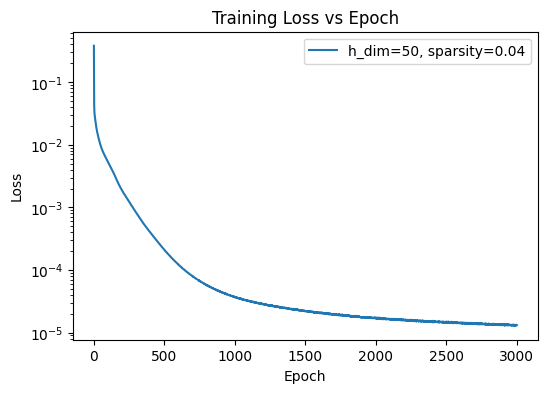

 Done: h_dim=50, sparsity_target=0.04, Final Loss=0.000013247


>>> Training SAE | h_dim=50, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.266489949
Epoch 500/3000 - Loss: 0.000156878
Epoch 1000/3000 - Loss: 0.000036175
Epoch 1500/3000 - Loss: 0.000024794
Epoch 2000/3000 - Loss: 0.000019979
Epoch 2500/3000 - Loss: 0.000017424
 Done: h_dim=50, sparsity_target=0.08, Final Loss=0.000015991



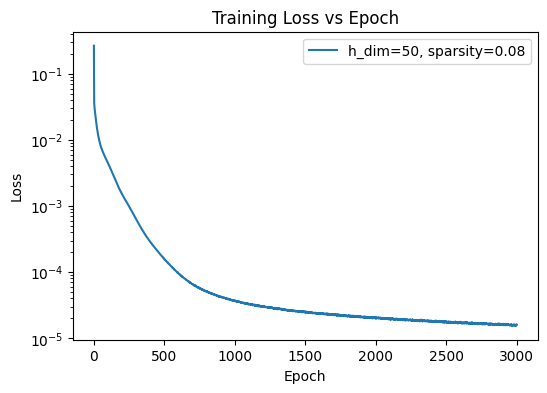

 Done: h_dim=50, sparsity_target=0.08, Final Loss=0.000015991


>>> Training SAE | h_dim=50, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.117708835
Epoch 500/3000 - Loss: 0.000106198
Epoch 1000/3000 - Loss: 0.000040955
Epoch 1500/3000 - Loss: 0.000028674
Epoch 2000/3000 - Loss: 0.000023192
Epoch 2500/3000 - Loss: 0.000020596
 Done: h_dim=50, sparsity_target=0.12, Final Loss=0.000018911



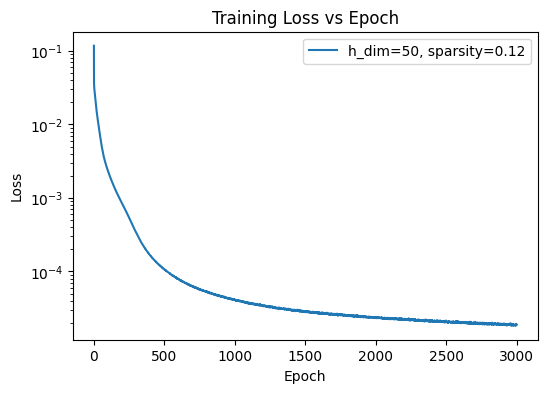

 Done: h_dim=50, sparsity_target=0.12, Final Loss=0.000018911


>>> Training SAE | h_dim=70, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.250075934
Epoch 500/3000 - Loss: 0.000321481
Epoch 1000/3000 - Loss: 0.000065975
Epoch 1500/3000 - Loss: 0.000030697
Epoch 2000/3000 - Loss: 0.000019828
Epoch 2500/3000 - Loss: 0.000015010
 Done: h_dim=70, sparsity_target=0.01, Final Loss=0.000012480



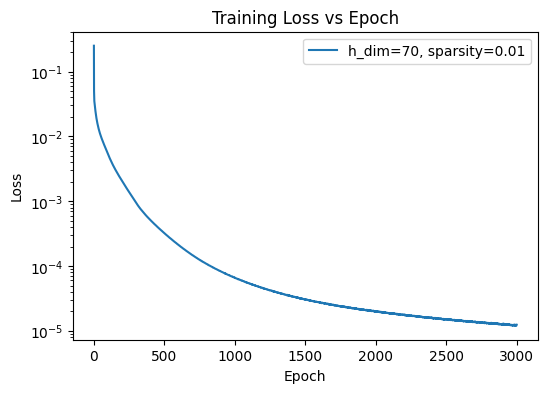

 Done: h_dim=70, sparsity_target=0.01, Final Loss=0.000012480


>>> Training SAE | h_dim=70, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.271415376
Epoch 500/3000 - Loss: 0.000164451
Epoch 1000/3000 - Loss: 0.000033923
Epoch 1500/3000 - Loss: 0.000020272
Epoch 2000/3000 - Loss: 0.000015148
Epoch 2500/3000 - Loss: 0.000012546
 Done: h_dim=70, sparsity_target=0.04, Final Loss=0.000010851



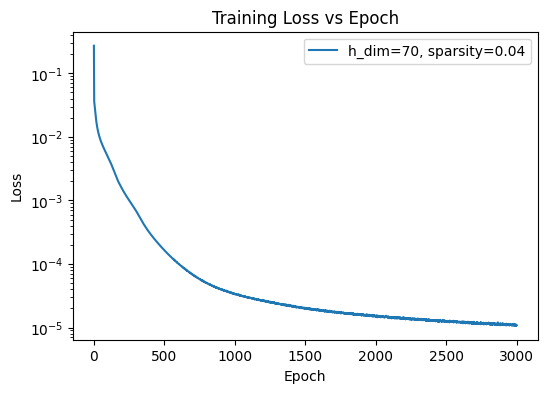

 Done: h_dim=70, sparsity_target=0.04, Final Loss=0.000010851


>>> Training SAE | h_dim=70, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.247395476
Epoch 500/3000 - Loss: 0.000107520
Epoch 1000/3000 - Loss: 0.000033704
Epoch 1500/3000 - Loss: 0.000022989
Epoch 2000/3000 - Loss: 0.000018778
Epoch 2500/3000 - Loss: 0.000015941
 Done: h_dim=70, sparsity_target=0.08, Final Loss=0.000014614



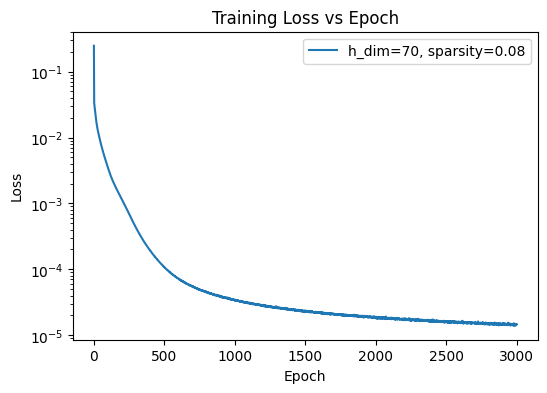

 Done: h_dim=70, sparsity_target=0.08, Final Loss=0.000014614


>>> Training SAE | h_dim=70, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.208631308
Epoch 500/3000 - Loss: 0.000117502
Epoch 1000/3000 - Loss: 0.000041124
Epoch 1500/3000 - Loss: 0.000028956
Epoch 2000/3000 - Loss: 0.000023217
Epoch 2500/3000 - Loss: 0.000019456
 Done: h_dim=70, sparsity_target=0.12, Final Loss=0.000017336



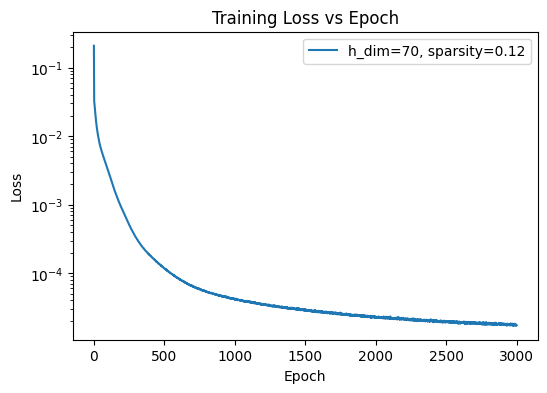

 Done: h_dim=70, sparsity_target=0.12, Final Loss=0.000017336


>>> Training SAE | h_dim=90, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.253735695
Epoch 500/3000 - Loss: 0.000301034
Epoch 1000/3000 - Loss: 0.000054257
Epoch 1500/3000 - Loss: 0.000024568
Epoch 2000/3000 - Loss: 0.000015087
Epoch 2500/3000 - Loss: 0.000010989
 Done: h_dim=90, sparsity_target=0.01, Final Loss=0.000008821



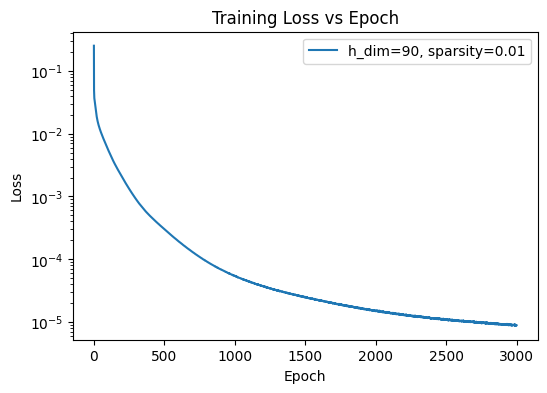

 Done: h_dim=90, sparsity_target=0.01, Final Loss=0.000008821


>>> Training SAE | h_dim=90, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.169456013
Epoch 500/3000 - Loss: 0.000113791
Epoch 1000/3000 - Loss: 0.000024877
Epoch 1500/3000 - Loss: 0.000015882
Epoch 2000/3000 - Loss: 0.000012798
Epoch 2500/3000 - Loss: 0.000010336
 Done: h_dim=90, sparsity_target=0.04, Final Loss=0.000009624



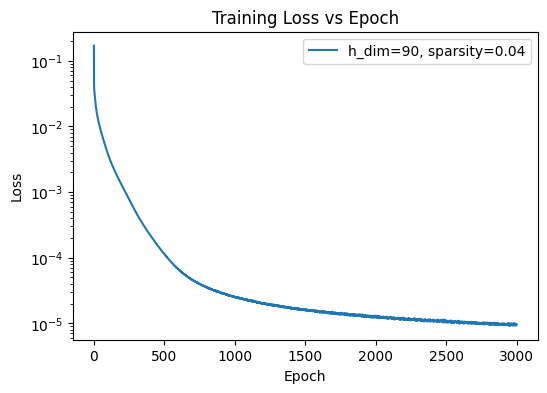

 Done: h_dim=90, sparsity_target=0.04, Final Loss=0.000009624


>>> Training SAE | h_dim=90, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.156443859
Epoch 500/3000 - Loss: 0.000096865
Epoch 1000/3000 - Loss: 0.000031154
Epoch 1500/3000 - Loss: 0.000020888
Epoch 2000/3000 - Loss: 0.000016358
Epoch 2500/3000 - Loss: 0.000013787
 Done: h_dim=90, sparsity_target=0.08, Final Loss=0.000012640



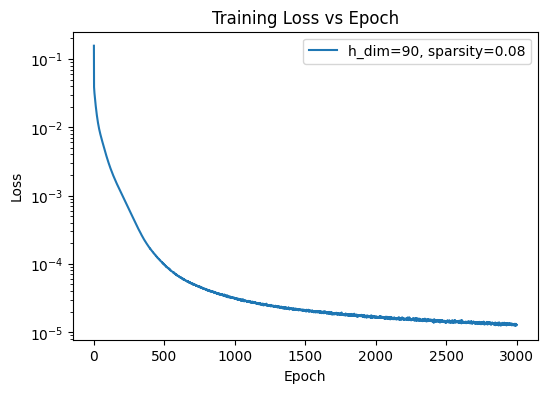

 Done: h_dim=90, sparsity_target=0.08, Final Loss=0.000012640


>>> Training SAE | h_dim=90, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.126758246
Epoch 500/3000 - Loss: 0.000108021
Epoch 1000/3000 - Loss: 0.000038173
Epoch 1500/3000 - Loss: 0.000025797
Epoch 2000/3000 - Loss: 0.000022397
Epoch 2500/3000 - Loss: 0.000019121
 Done: h_dim=90, sparsity_target=0.12, Final Loss=0.000017718



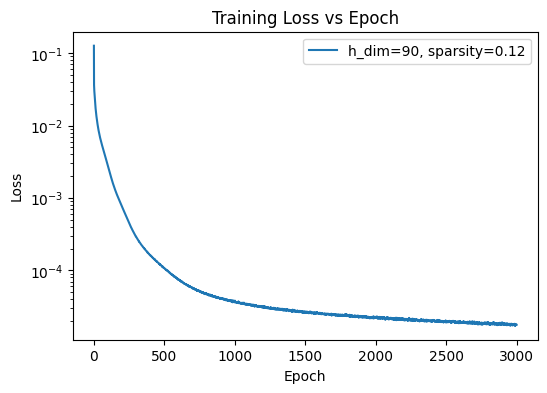

 Done: h_dim=90, sparsity_target=0.12, Final Loss=0.000017718


>>> Training SAE | h_dim=110, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.159953996
Epoch 500/3000 - Loss: 0.000287543
Epoch 1000/3000 - Loss: 0.000062987
Epoch 1500/3000 - Loss: 0.000025915
Epoch 2000/3000 - Loss: 0.000012433
Epoch 2500/3000 - Loss: 0.000009254
 Done: h_dim=110, sparsity_target=0.01, Final Loss=0.000007662



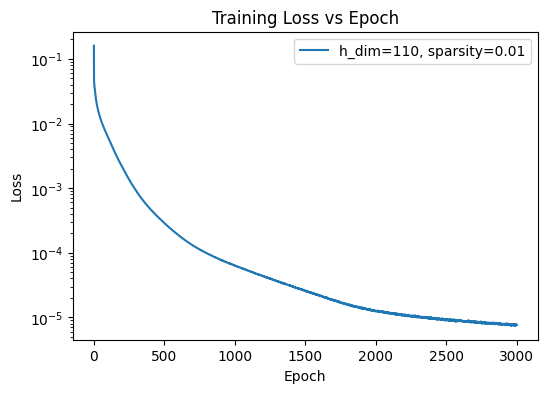

 Done: h_dim=110, sparsity_target=0.01, Final Loss=0.000007662


>>> Training SAE | h_dim=110, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.233001582
Epoch 500/3000 - Loss: 0.000151901
Epoch 1000/3000 - Loss: 0.000028765
Epoch 1500/3000 - Loss: 0.000017798
Epoch 2000/3000 - Loss: 0.000013383
Epoch 2500/3000 - Loss: 0.000011610
 Done: h_dim=110, sparsity_target=0.04, Final Loss=0.000010011



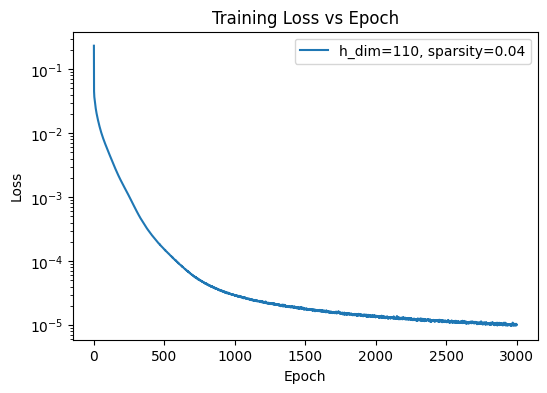

 Done: h_dim=110, sparsity_target=0.04, Final Loss=0.000010011


>>> Training SAE | h_dim=110, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.154252025
Epoch 500/3000 - Loss: 0.000093479
Epoch 1000/3000 - Loss: 0.000030603
Epoch 1500/3000 - Loss: 0.000020581
Epoch 2000/3000 - Loss: 0.000017144
Epoch 2500/3000 - Loss: 0.000014988
 Done: h_dim=110, sparsity_target=0.08, Final Loss=0.000013779



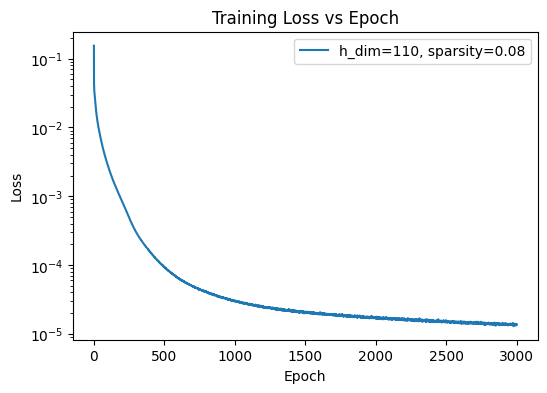

 Done: h_dim=110, sparsity_target=0.08, Final Loss=0.000013779


>>> Training SAE | h_dim=110, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.156415397
Epoch 500/3000 - Loss: 0.000099751
Epoch 1000/3000 - Loss: 0.000037220
Epoch 1500/3000 - Loss: 0.000026329
Epoch 2000/3000 - Loss: 0.000022042
Epoch 2500/3000 - Loss: 0.000018687
 Done: h_dim=110, sparsity_target=0.12, Final Loss=0.000016753



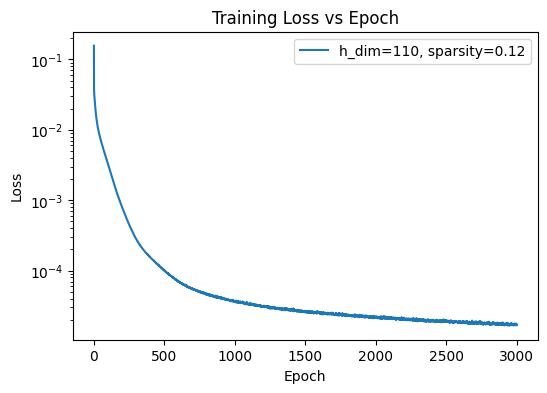

 Done: h_dim=110, sparsity_target=0.12, Final Loss=0.000016753


>>> Training SAE | h_dim=130, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.161349632
Epoch 500/3000 - Loss: 0.000258684
Epoch 1000/3000 - Loss: 0.000048514
Epoch 1500/3000 - Loss: 0.000021105
Epoch 2000/3000 - Loss: 0.000013421
Epoch 2500/3000 - Loss: 0.000010002
 Done: h_dim=130, sparsity_target=0.01, Final Loss=0.000008223



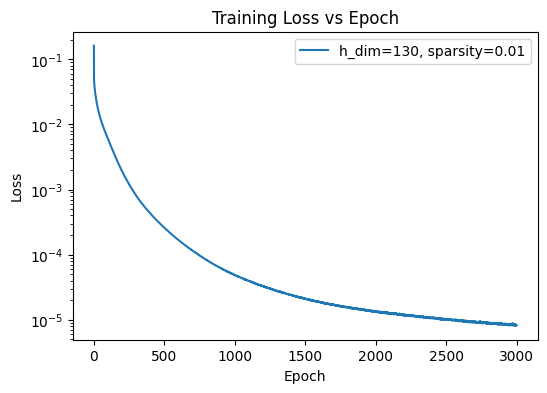

 Done: h_dim=130, sparsity_target=0.01, Final Loss=0.000008223


>>> Training SAE | h_dim=130, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.132072280
Epoch 500/3000 - Loss: 0.000131224
Epoch 1000/3000 - Loss: 0.000024260
Epoch 1500/3000 - Loss: 0.000015660
Epoch 2000/3000 - Loss: 0.000011833
Epoch 2500/3000 - Loss: 0.000010132
 Done: h_dim=130, sparsity_target=0.04, Final Loss=0.000009432



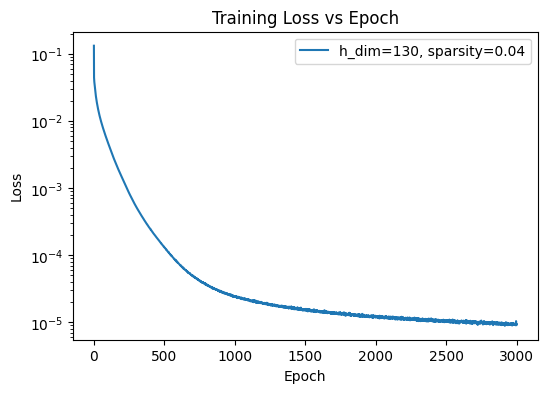

 Done: h_dim=130, sparsity_target=0.04, Final Loss=0.000009432


>>> Training SAE | h_dim=130, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.126155234
Epoch 500/3000 - Loss: 0.000086847
Epoch 1000/3000 - Loss: 0.000030771
Epoch 1500/3000 - Loss: 0.000020376
Epoch 2000/3000 - Loss: 0.000016663
Epoch 2500/3000 - Loss: 0.000015171
 Done: h_dim=130, sparsity_target=0.08, Final Loss=0.000013669



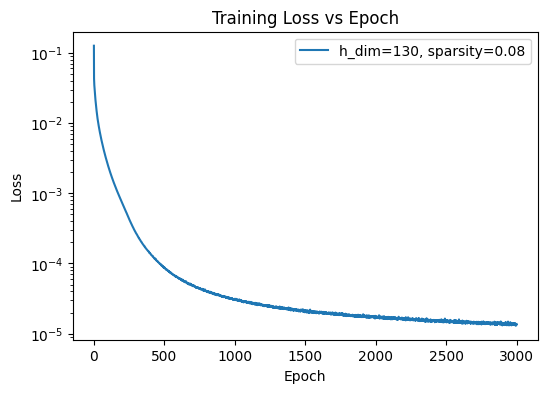

 Done: h_dim=130, sparsity_target=0.08, Final Loss=0.000013669


>>> Training SAE | h_dim=130, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.257964716
Epoch 500/3000 - Loss: 0.000105923
Epoch 1000/3000 - Loss: 0.000038249
Epoch 1500/3000 - Loss: 0.000027618
Epoch 2000/3000 - Loss: 0.000023668
Epoch 2500/3000 - Loss: 0.000020479
 Done: h_dim=130, sparsity_target=0.12, Final Loss=0.000017793



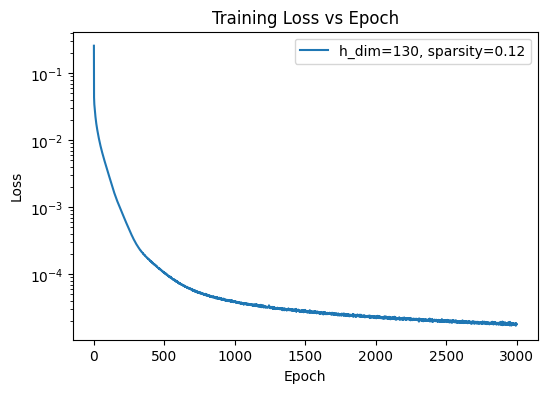

 Done: h_dim=130, sparsity_target=0.12, Final Loss=0.000017793


 Best SAE configuration: h_dim=110, sparsity_target=0.01, loss=0.000007662


In [13]:
# Train SAE for different latent dimensions
def train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
              sparsity_lambda, lr, n_epochs, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_dim = hidden_tensor.shape[1]
    sae = SparseAutoencoder(in_dim, h_dim, sparsity_lambda, sparsity_target).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
    epoch_losses = []

    print(f"\n>>> Training SAE | h_dim={h_dim}, sparsity_target={sparsity_target}")
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            encoded, decoded = sae(batch_x)
            loss = sae.loss_function(decoded, batch_x, encoded)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.9f}")

    final_loss = epoch_losses[-1]
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")

    plt.figure(figsize=(6,4))
    plt.plot(range(n_epochs), epoch_losses, label=f"h_dim={h_dim}, sparsity={sparsity_target}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Training Loss vs Epoch")
    plt.legend()
    plt.show()

    final_loss = total_loss / len(dataloader)
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")
    return final_loss, sae


# Experiment configurations

h_dims_list = [50,70,90,110,130]      # hidden layer sizes
sparsity_targets = [0.01,0.04,0.08,0.12]   # sparsity targets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = {}
best_loss = float('inf')
best_config = None
best_model = None

# Train models & track best configuration
for h_dim in h_dims_list:
    losses = []
    for sparsity_target in sparsity_targets:
        final_loss, sae_model = train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
                                          sparsity_lambda=2e-4, lr=1e-3, n_epochs=3000, device=device)
        losses.append(final_loss)

        # Track the best model
        if final_loss < best_loss:
            best_loss = final_loss
            best_config = (h_dim, sparsity_target)
            best_model = sae_model

    results[h_dim] = losses

print(f"\n Best SAE configuration: h_dim={best_config[0]}, sparsity_target={best_config[1]}, loss={best_loss:.9f}")

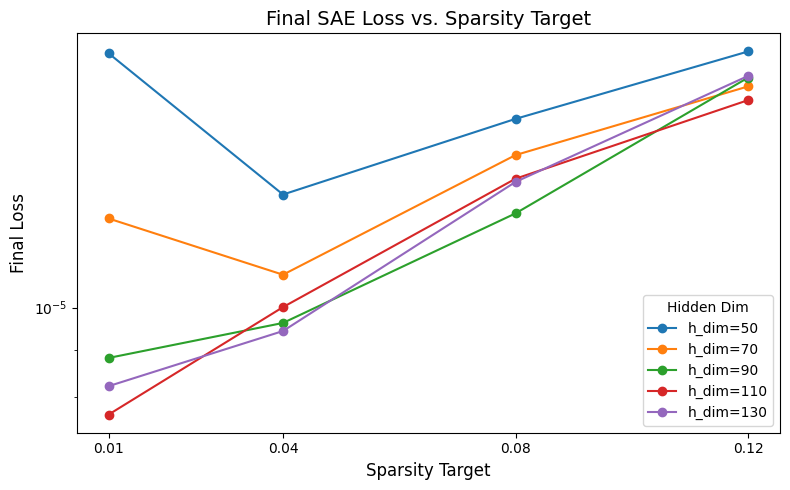

In [14]:
plt.figure(figsize=(8, 5))
for h_dim, losses in results.items():
    plt.plot(sparsity_targets, losses, marker='o', label=f'h_dim={h_dim}')
plt.xlabel('Sparsity Target', fontsize=12)
plt.ylabel('Final Loss', fontsize=12)
plt.title('Final SAE Loss vs. Sparsity Target', fontsize=14)
plt.legend(title='Hidden Dim')
plt.xticks(sparsity_targets)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [30]:
# Assume your best trained SAE model
sae = best_model
sae.eval()

#  Take any mini-batch from your data
any_batch, _ = next(iter(dataloader))  # use your dataloader
any_batch = any_batch.to(device)

with torch.no_grad():
    encoded_batch, _ = sae(any_batch)  # encoded activations for the batch

encoded_batch_np = encoded_batch.cpu().numpy()  # shape: (batch_size, n_neurons)
num_samples, num_neurons = encoded_batch_np.shape
print(f"Mini-batch activations shape: {encoded_batch_np.shape}")

#  Step 2: Compute per-neuron thresholds (top-K average)
K = 30  # number of top activations to average
thresholds = np.zeros(num_neurons)

for n in range(num_neurons):
    topk_values = np.sort(encoded_batch_np[:, n])[-K:]  # top K activations for neuron n
    thresholds[n] = np.mean(topk_values)

print("Computed per-neuron thresholds.")


Mini-batch activations shape: (135, 110)
Computed per-neuron thresholds.


In [35]:
n_points_dense = 20
x_vals_t = np.linspace(0, np.pi, n_points_dense)
y_vals_t = np.linspace(0, np.pi, n_points_dense)
t_vals_t = np.linspace(0, 1, n_points_dense)
X_grid_t, Y_grid, T_grid = np.meshgrid(x_vals_t, y_vals_t, t_vals_t, indexing="ij")
x_flat_t = X_grid_t.flatten()
y_flat_t = Y_grid.flatten()
t_flat_t = T_grid.flatten()

dense_test = torch.tensor(np.stack([x_flat_t, y_flat_t, t_flat_t], axis=1), dtype=torch.float32)

# -2 because last hidden layer (just before final output)
hook_handle = model.net[-2].register_forward_hook(get_activation('last_hidden'))

# Run the model
model.eval()
with torch.no_grad():
    _ = model(dense_test)

# Extract activations from the global 'activations' dictionary
last_hidden_dense = activations['last_hidden'].cpu().numpy()
print("Dense activations shape:", last_hidden_dense.shape)

# Remove hook (clean up)
hook_handle.remove()


Dense activations shape: (8000, 15)


Encoded dense activations shape: (8000, 110)


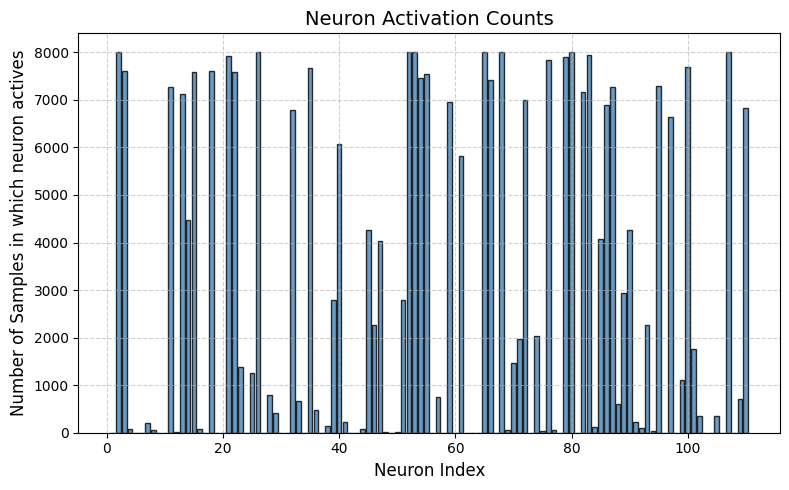

In [44]:
# Step 3: Pass dense activations through trained SAE encoder
dense_tensor_test = torch.tensor(last_hidden_dense, dtype=torch.float32).to(device)

sae.eval()
with torch.no_grad():
    encoded_dense, _ = sae(dense_tensor_test)

encoded_dense_np = encoded_dense.cpu().numpy()
print("Encoded dense activations shape:", encoded_dense_np.shape)

# Determine active neurons using thresholds

active_mask = encoded_dense_np >= thresholds  # shape: (N_dense, num_neurons)
active_ratio = active_mask.mean(axis=0)       # how often each neuron is active

# Count how many samples activated each neuron

neuron_activity_counts = np.sum(active_mask, axis=0)  # shape: (num_neurons,)
total_samples = active_mask.shape[0]


#  Plot histogram of neuron activity
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(neuron_activity_counts)) + 1,
        neuron_activity_counts,
        color='steelblue', edgecolor='black', alpha=0.8)

plt.xlabel("Neuron Index", fontsize=12)
plt.ylabel("Number of Samples in which neuron actives", fontsize=12)
plt.title("Neuron Activation Counts", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Now we want to check which sample input activates most of feature/neurosn in the best trained SAE

In [53]:
sample_activity_counts = np.sum(active_mask, axis=1)  # shape: (N_dense,)

# Sort samples by number of active neurons
top_k = 20  # or any number you want
top_indices = np.argsort(-sample_activity_counts)[:top_k]

print(f"\nTop {top_k} most neuron-active samples:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. Sample {idx}: activated {sample_activity_counts[idx]} neurons")



Top 20 most neuron-active samples:
1. Sample 2: activated 51 neurons
2. Sample 3: activated 50 neurons
3. Sample 1: activated 49 neurons
4. Sample 0: activated 49 neurons
5. Sample 401: activated 48 neurons
6. Sample 4: activated 47 neurons
7. Sample 402: activated 47 neurons
8. Sample 403: activated 47 neurons
9. Sample 801: activated 47 neurons
10. Sample 802: activated 47 neurons
11. Sample 1202: activated 47 neurons
12. Sample 23: activated 47 neurons
13. Sample 822: activated 46 neurons
14. Sample 821: activated 46 neurons
15. Sample 22: activated 46 neurons
16. Sample 820: activated 46 neurons
17. Sample 800: activated 46 neurons
18. Sample 423: activated 46 neurons
19. Sample 421: activated 46 neurons
20. Sample 404: activated 46 neurons
